In [1]:
from cil.framework import  AcquisitionGeometry
from cil.optimisation.algorithms import Algorithm
from cil.optimisation.functions import IndicatorBox, LeastSquares, BlockFunction
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D

import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Define SAGAGradientFunction
import sys
cil_path = '/home/user/CILworkspace/CIL/'
fun_path = 'Wrappers/Python/cil/optimisation/functions'
sys.path.append(cil_path + fun_path)

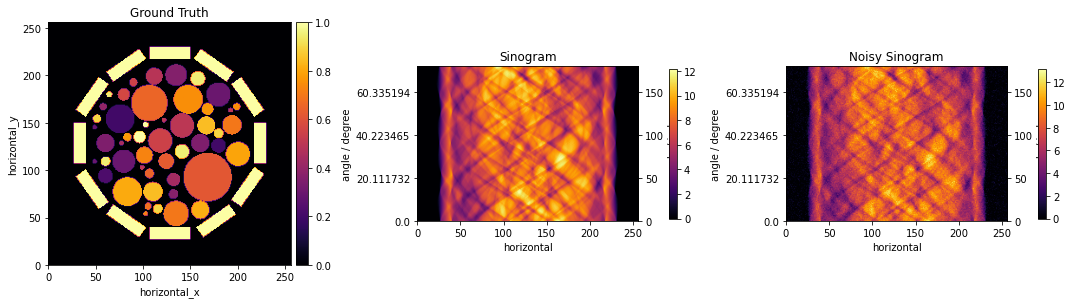

In [3]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device='gpu')

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
noise_scale = 1

gaussian_var = 0.5 * noise_scale
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size=ag.shape)

noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array < 0] = 0

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title=['Ground Truth', 'Sinogram', 'Noisy Sinogram'], num_cols=3, cmap='inferno')

In [4]:
from cil.optimisation.algorithms.SPDHG import SPDHG
from cil.processors import Slicer
from cil.optimisation.functions import MixedL21Norm, BlockFunction
from cil.optimisation.operators import GradientOperator, BlockOperator

"""     :param operator: BlockOperator of Linear Operators
        :param f: BlockFunction, each function with "simple" proximal of its conjugate.
        :param g: Convex function with "simple" proximal 
        :param sigma: list of Step size parameters for dual problem
        :param tau: Step size parameter for primal problem
        :param initial: Initial guess ( Default initial = 0)
        :param prob: List of probabilities''' """

Grad1 = GradientOperator(ig, correlation='SpaceChannels')


# Define number of subsets
n_subsets = 10

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's
for i in range(n_subsets):
    # Total number of angles
    n_angles = len(ag.angles)
    # Divide the data into subsets
    data_subset = Slicer(roi = {'angle' : (i,n_angles,n_subsets)})(noisy_sino)

    # Define A_i and put into list 
    ageom_subset = data_subset.geometry
    Ai = ProjectionOperator(ig, ageom_subset)
    A_subsets.append(Ai)

    # Define F_i and put into list
    fi = LeastSquares(Ai, b = data_subset)
    f_subsets.append(fi)

alpha = 1

# Define F and K
K = BlockOperator(*A_subsets, Grad1)
F = BlockFunction(*f_subsets, alpha*MixedL21Norm())


# Define F and K
F = BlockFunction(*f_subsets)

# SPDHG
num_epochs = 100
f_gd = LeastSquares(A, noisy_sino)
initial = ig.allocate(0)
step_size = 1 / f_gd.L

g_fun = IndicatorBox(lower=0)
spdhg = SPDHG(operator=A, f=f_gd, g=g_fun,
                     step_size=step_size, update_objective_interval=1,
                     max_iteration=1000)
ista.run(num_epochs, verbose=0)

show2D([ista.solution],
       title=["ISTA"],
       origin="upper",
       fix_range=(0,1), num_cols=2,
       cmap='inferno')

plt.figure()
plt.semilogy(ista.objective, label="ISTA")

plt.legend()
plt.ylabel('Epochs')
plt.xlabel('Objective function')
plt.show()

Initialised GradientOperator with C backend running with  16  threads


NameError: name 'BlockFunction' is not defined

ISTA setting up
ISTA configured
ISTA setting up
ISTA configured
ISTA setting up
ISTA configured



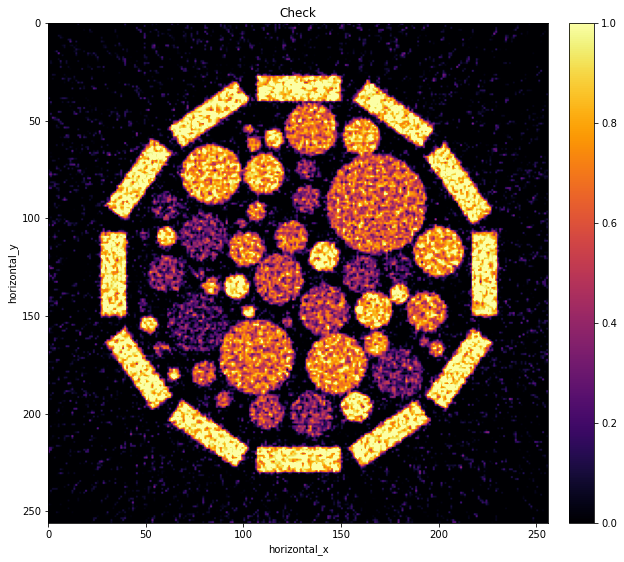

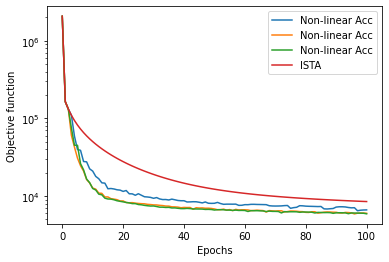

[2071186.0, 164043.4375, 131884.546875, 109890.46875, 59292.7421875, 39803.15625, 38850.234375, 27860.5078125, 27605.95703125, 22412.134765625, 20967.33984375, 17917.1796875, 16712.763671875, 14809.828125, 14663.2470703125, 12417.01171875, 12511.90234375, 12336.744140625, 12047.080078125, 11927.67578125, 11482.884765625, 11788.173828125, 10700.353515625, 10675.0400390625, 10241.8896484375, 10712.470703125, 10243.935546875, 9798.66796875, 9729.537109375, 9617.7236328125, 9358.4482421875, 9560.625, 9180.427734375, 9012.8935546875, 9025.1953125, 8901.298828125, 9132.0673828125, 8956.33203125, 8771.2939453125, 8705.8408203125, 8708.298828125, 8390.4140625, 8412.5556640625, 8455.423828125, 8442.462890625, 8320.205078125, 8164.0234375, 8392.2978515625, 8083.35107421875, 8050.197265625, 8071.4716796875, 8282.818359375, 8012.73583984375, 7830.8642578125, 7865.595703125, 7867.91015625, 7858.392578125, 7872.48193359375, 7589.45458984375, 7609.0732421875, 7748.99609375, 7741.7861328125, 7822.8198

In [8]:
class Online_RNA(Algorithm):
    r"""
        Online regularised non-linear acceleration

        'Online Regularized Nonlinear Acceleration'
        Damien Scieur · Edouard Oyallon · Alexandre d'Aspremont · Francis Bach
        
        https://arxiv.org/pdf/1805.09639.pdf

        .. math:: x_N = g(y_{N-1}) \;  y_N = RNA(X,Y,\lambda,\beta)

        Parameters
        ----------
        algo : Algorithm
                Algorithm that you'd like accelerating, i.e. ISTA/FISTA/PDHG... The "g" in: x_{i+1} = g(x_i)
        RNA_reg_param : positive :obj:`float`, default = None
            Regularisation parameter for RNA
        N : positive :obj:`int`, default = 5
            Number of iterations saved in the memory.
        beta : positive/negative :obj:`float`, default = -1
            Mixing parameter for Anderson-type acceleration (beta=-1 for no mixing)
        kwargs: Keyword arguments
            Arguments from the base class :class:`.Algorithm`.
    """

    def  __init__(self, algo=None, RNA_reg_param=None, N=5, beta=-1, **kwargs):

        super(Online_RNA, self).__init__(**kwargs)

        self.set_up(algo=algo, RNA_reg_param=RNA_reg_param, N=N, beta=beta)


    def set_up(self, algo, RNA_reg_param, N, beta):
        self.algo = algo
        self.RNA_reg_param = RNA_reg_param
        self.N = N
        self.beta = beta
        self.configured = True
        self.Y = self.algo.x.array.ravel()[None].T
        self.algo.__next__()
        self.X =  self.algo.x_old.array.ravel()[None].T

    def RNA(self):
        Res = self.X-self.Y
        e = np.ones((Res.shape[1], 1))
        if self.iteration <= 1:
            Res_norm = 1
        else:
            Res_norm = np.linalg.norm(Res,2)**2
        c_la = np.linalg.lstsq(Res.T@Res + self.RNA_reg_param * Res_norm * np.eye(Res.shape[1]), e, rcond = None)[0]
        c_la /= np.sum(c_la)
        return (self.Y - self.beta * Res) @ c_la

    def update(self):
        if self.iteration == 0:
            x_extra = self.algo.x_old.array.ravel()[None].T
        else:
            x_extra = self.RNA()
            
            self.algo.x_old.fill(np.reshape(x_extra,self.algo.x.shape))

            self.x = self.algo.x_old

            """ if self.algo.g.lower is not None and self.algo.g.upper is not None:
                self.x = self.algo.g.proximal(self.x,1) """

        self.algo.__next__()
    
        if self.iteration <= 1:
            self.Y = x_extra.copy()
            self.X = self.algo.x_old.copy().array.ravel()[None].T
        elif self.iteration <= (self.N):
            self.Y = np.hstack((self.Y, x_extra))
            self.X = np.hstack((self.X, self.algo.x_old.copy().array.ravel()[None].T))
        else:
            self.Y = np.hstack((self.Y[:, 1:], x_extra))
            self.X = np.hstack((self.X[:, 1:], self.algo.x_old.copy().array.ravel()[None].T))
            
    def update_objective(self):
        self.loss.append(self.algo.loss[-1])

ista2 = ISTA(initial=initial, f=f_gd, g=g_fun,
                     step_size=step_size, update_objective_interval=1,
                     max_iteration=1000)

check = Online_RNA(ista2, RNA_reg_param = 1e-5, N = 10, beta = -1, max_iteration=1000)
check.run(100, verbose=0)

ista2 = ISTA(initial=initial, f=f_gd, g=g_fun,
                     step_size=step_size, update_objective_interval=1,
                     max_iteration=1000)

check1 = Online_RNA(ista2, RNA_reg_param = 1e-5, N = 10, beta = -5, max_iteration=1000)
check1.run(100, verbose=0)

ista2 = ISTA(initial=initial, f=f_gd, g=g_fun,
                     step_size=step_size, update_objective_interval=1,
                     max_iteration=1000)

check2 = Online_RNA(ista2, RNA_reg_param = 1e-5, N = 10, beta = -10, max_iteration=1000)
check2.run(100, verbose=0)

print()
show2D([check.solution],
       title=["Check"],
       origin="upper",
       fix_range=(0,1), num_cols=2,
       cmap='inferno')

plt.figure()
plt.semilogy(check.objective, label="Non-linear Acc -1")
plt.semilogy(check1.objective, label="Non-linear Acc -5")
plt.semilogy(check2.objective, label="Non-linear Acc -10")
plt.semilogy(ista.objective, label="ISTA")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.show()
print(check.objective)
print(ista.objective)

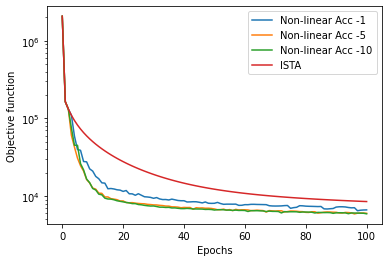

[2071186.0, 164043.4375, 131884.546875, 109890.46875, 59292.7421875, 39803.15625, 38850.234375, 27860.5078125, 27605.95703125, 22412.134765625, 20967.33984375, 17917.1796875, 16712.763671875, 14809.828125, 14663.2470703125, 12417.01171875, 12511.90234375, 12336.744140625, 12047.080078125, 11927.67578125, 11482.884765625, 11788.173828125, 10700.353515625, 10675.0400390625, 10241.8896484375, 10712.470703125, 10243.935546875, 9798.66796875, 9729.537109375, 9617.7236328125, 9358.4482421875, 9560.625, 9180.427734375, 9012.8935546875, 9025.1953125, 8901.298828125, 9132.0673828125, 8956.33203125, 8771.2939453125, 8705.8408203125, 8708.298828125, 8390.4140625, 8412.5556640625, 8455.423828125, 8442.462890625, 8320.205078125, 8164.0234375, 8392.2978515625, 8083.35107421875, 8050.197265625, 8071.4716796875, 8282.818359375, 8012.73583984375, 7830.8642578125, 7865.595703125, 7867.91015625, 7858.392578125, 7872.48193359375, 7589.45458984375, 7609.0732421875, 7748.99609375, 7741.7861328125, 7822.8198

In [9]:
plt.figure()
plt.semilogy(check.objective, label="Non-linear Acc -1")
plt.semilogy(check1.objective, label="Non-linear Acc -5")
plt.semilogy(check2.objective, label="Non-linear Acc -10")
plt.semilogy(ista.objective, label="ISTA")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.show()